## Correlation and Variance Inflation, Car ownership

This is a notebook to compute variance inflation factors and correlation coefficients between urban form and selected other features for models of car ownership in 11 European cities.

In general, we try to avoid VIF>5, and correlation factors > 0.7 (absolute value)

In [1]:
# load in required packages
import numpy as np
import pandas as pd
import geopandas as gpd
import shap
import re
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, cross_validate, GroupKFold, StratifiedGroupKFold, RepeatedKFold, StratifiedKFold, GridSearchCV, KFold
from sklearn import metrics, linear_model
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier, XGBRegressor
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import pickle
import os

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import seaborn as sns

cities_all=['Berlin','Dresden','Düsseldorf','Frankfurt am Main','Kassel','Leipzig','Magdeburg','Potsdam','Clermont','Dijon','Lille','Lyon','Montpellier','Nantes','Nimes','Paris','Toulouse','Madrid','Wien','France_other','Germany_other']
countries=['Germany','Germany','Germany','Germany','Germany','Germany','Germany','Germany','France','France','France','France','France','France','France','France','France','Spain','Austria','France','Germany']



pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
def vif_corr(city):
    country=countries[cities_all.index(city)]
    print(city, country)

    if city=='Germany_other':
        city0='Dresden'
        df0=pd.read_csv('../outputs/Combined/' + city0 + '_co_UF.csv')
        #print(len(df0.columns), 'columns in the data for ', city0)
        df0['City']=city0
        df_all=df0.copy()

        cities0=['Leipzig','Magdeburg','Potsdam','Frankfurt am Main','Düsseldorf','Kassel']
        for city1 in cities0:
            #print(city1)
            df1=pd.read_csv('../outputs/Combined/' + city1 + '_co_UF.csv')
            #print(len(df1.columns), 'columns in the data for ', city1)
            df1['City']=city1
            if len(df1.columns==df_all.columns):
                df_all=pd.concat([df_all,df1])
                #print(city1, 'added.')
                #print(len(df_all), 'rows in the combined dataframe')
        df_all['HHNR']=df_all['City']+'_'+df_all['HHNR'].astype(int).astype(str)

        df=df_all.copy()
    elif city=='France_other':
        city0='Clermont'
        df0=pd.read_csv('../outputs/Combined/' + city0 + '_co_UF.csv')
        #print(len(df0.columns), 'columns in the data for ', city0)
        df0['City']=city0
        df_all=df0.copy()

        cities0=['Toulouse']
        for city1 in cities0:
            #print(city1)
            df1=pd.read_csv('../outputs/Combined/' + city1 + '_co_UF.csv')
            #print(len(df1.columns), 'columns in the data for ', city1)
            df1['City']=city1
            if len(df1.columns==df_all.columns):
                df_all=pd.concat([df_all,df1])
                #print(city1, 'added.')
                #print(len(df_all), 'rows in the combined dataframe')
        df_all['HHNR']=df_all['City']+'_'+df_all['HHNR'].astype(int).astype(str)
        df=df_all.copy()
    else: df=pd.read_csv('../outputs/Combined/' + city + '_co_UF.csv')

    df=df.loc[:,( 'HHNR','Res_geocode',#'Dist_group', # IDs, trip geocodes, home-Res_geocode
    'HHSize','IncomeDetailed_Numeric','HHType_simp','maxAgeHH',# household details, omit  'IncomeDetailed', 'HHType', 
    'UniversityEducation', 'InEmployment', 'AllRetired', # personal-based details
    'UrbPopDensity', 'UrbBuildDensity','DistSubcenter', 'DistCenter', 'transit_accessibility',
    'bike_lane_share', 'IntersecDensity', 'street_length', 'LU_UrbFab', 'LU_Comm',# 'LU_Urban',
    # target: car ownership
    'CarOwnershipHH')
    ]

    df.loc[df['HHType_simp'].isin(['Single_Female_Parent','Single_Male_Parent']),'HHType_simp']='Single_Parent'
    df=df.loc[df['UrbPopDensity']<80000,]   
    # remove high building density outliers (For Leipzig)
    df=df.loc[df['UrbBuildDensity']<1e8,]   
    df=df.loc[df['maxAgeHH']>0,]  
    df.dropna(inplace=True)
    
    # identify the feature columns
    N_non_feature=2 # how many non-features are at the start of the df
    cols=df.columns
    newcols=(df.columns[:N_non_feature].tolist()) + ('FeatureO' +'_'+ cols[N_non_feature:-1]).tolist() + (df.columns[-1:].tolist())
    # change column names
    df.set_axis(newcols,axis=1,inplace=True)
    df = df.reset_index(drop=True)
    df0=df.copy()

    # convert  all categorical variables to dummies
    df_Cat=df.select_dtypes('object')[[col for col in df.select_dtypes('object').columns if "FeatureO" in col]]
    for col in df_Cat:
        dum=pd.get_dummies(df[[col]])
        df = pd.concat([df, dum], axis = 1)
        # remove the original categorical columns
    df.drop(df_Cat.columns.tolist(),axis=1,inplace=True)
    # HPO with full dataset, grouping by individual person

    X=df[[col for col in df.columns if "FeatureO" in col]]

    return X

In [3]:
X=vif_corr('Berlin')
X_disp=[re.sub('FeatureO_','', x) for x in X.columns]
X.columns=X_disp
X=X.loc[:,['UrbPopDensity','DistSubcenter','DistCenter','UrbBuildDensity','IntersecDensity','street_length','bike_lane_share','transit_accessibility','LU_UrbFab','LU_Comm']]
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

Berlin Germany
                  Feature         VIF
0                   const  210.558785
1           UrbPopDensity    3.841255
2           DistSubcenter    1.372947
3              DistCenter    3.667287
4         UrbBuildDensity    4.037912
5         IntersecDensity    3.000203
6           street_length    1.962193
7         bike_lane_share    1.183032
8   transit_accessibility    4.026973
9               LU_UrbFab    1.974597
10                LU_Comm    1.992161


,UrbPopDensity,DistSubcenter,DistCenter,UrbBuildDensity,IntersecDensity,street_length,bike_lane_share,transit_accessibility,LU_UrbFab,LU_Comm
UrbPopDensity,1.000,-0.461,-0.655,0.745,0.619,-0.450,0.114,0.688,0.497,-0.054
DistSubcenter,-0.461,1.000,0.406,-0.415,-0.310,0.168,-0.094,-0.430,-0.226,-0.152
DistCenter,-0.655,0.406,1.000,-0.735,-0.525,0.506,-0.310,-0.796,-0.159,-0.329
UrbBuildDensity,0.745,-0.415,-0.735,1.000,0.528,-0.458,0.264,0.779,0.269,0.328
IntersecDensity,0.619,-0.310,-0.525,0.528,1.000,-0.663,0.051,0.595,0.563,-0.150
street_length,-0.450,0.168,0.506,-0.458,-0.663,1.000,-0.137,-0.491,-0.321,-0.039
bike_lane_share,0.114,-0.094,-0.310,0.264,0.051,-0.137,1.000,0.284,-0.079,0.284
transit_accessibility,0.688,-0.430,-0.796,0.779,0.595,-0.491,0.284,1.000,0.331,0.267
LU_UrbFab,0.497,-0.226,-0.159,0.269,0.563,-0.321,-0.079,0.331,1.000,-0.387
LU_Comm,-0.054,-0.152,-0.329,0.328,-0.150,-0.039,0.284,0.267,-0.387,1.000


Moderately high VIF (4.0) for transit access, building density in Berlin. Also high correlations between population density and built-up density, and transit accessibility with built-up density. 

Dropping built-up density brings all VIF <4 and we just have one remaining correlation >0.7 (transit access and distance to center, 0.796), but we keep both out of interest to see effects for both features.

In [11]:
X.drop(columns='UrbBuildDensity',inplace=True)
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

                 Feature         VIF
0                  const  210.503379
1          UrbPopDensity    2.884407
2          DistSubcenter    1.371632
3             DistCenter    3.648284
4        IntersecDensity    2.984447
5          street_length    1.960857
6        bike_lane_share    1.179188
7  transit_accessibility    3.716122
8              LU_UrbFab    1.974117
9                LU_Comm    1.727602


,UrbPopDensity,DistSubcenter,DistCenter,IntersecDensity,street_length,bike_lane_share,transit_accessibility,LU_UrbFab,LU_Comm
UrbPopDensity,1.000,-0.461,-0.655,0.619,-0.450,0.114,0.688,0.497,-0.054
DistSubcenter,-0.461,1.000,0.406,-0.310,0.168,-0.094,-0.430,-0.226,-0.152
DistCenter,-0.655,0.406,1.000,-0.525,0.506,-0.310,-0.796,-0.159,-0.329
IntersecDensity,0.619,-0.310,-0.525,1.000,-0.663,0.051,0.595,0.563,-0.150
street_length,-0.450,0.168,0.506,-0.663,1.000,-0.137,-0.491,-0.321,-0.039
bike_lane_share,0.114,-0.094,-0.310,0.051,-0.137,1.000,0.284,-0.079,0.284
transit_accessibility,0.688,-0.430,-0.796,0.595,-0.491,0.284,1.000,0.331,0.267
LU_UrbFab,0.497,-0.226,-0.159,0.563,-0.321,-0.079,0.331,1.000,-0.387
LU_Comm,-0.054,-0.152,-0.329,-0.150,-0.039,0.284,0.267,-0.387,1.000


In [4]:
X=vif_corr('Paris')
X_disp=[re.sub('FeatureO_','', x) for x in X.columns]
X.columns=X_disp
X=X.loc[:,['UrbPopDensity','DistSubcenter','DistCenter','UrbBuildDensity','IntersecDensity','street_length','bike_lane_share','transit_accessibility','LU_UrbFab','LU_Comm']]
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

Paris France
                  Feature         VIF
0                   const  430.890324
1           UrbPopDensity    6.166251
2           DistSubcenter    1.569497
3              DistCenter    4.581187
4         UrbBuildDensity    9.635160
5         IntersecDensity    4.577240
6           street_length    2.301917
7         bike_lane_share    4.220867
8   transit_accessibility   11.699497
9               LU_UrbFab    2.543978
10                LU_Comm    2.025443


,UrbPopDensity,DistSubcenter,DistCenter,UrbBuildDensity,IntersecDensity,street_length,bike_lane_share,transit_accessibility,LU_UrbFab,LU_Comm
UrbPopDensity,1.000,-0.379,-0.770,0.810,0.687,-0.428,0.726,0.781,0.514,-0.322
DistSubcenter,-0.379,1.000,0.541,-0.453,-0.411,0.114,-0.343,-0.410,-0.113,-0.037
DistCenter,-0.770,0.541,1.000,-0.776,-0.626,0.282,-0.733,-0.808,-0.290,0.125
UrbBuildDensity,0.810,-0.453,-0.776,1.000,0.562,-0.286,0.701,0.891,0.272,-0.045
IntersecDensity,0.687,-0.411,-0.626,0.562,1.000,-0.667,0.511,0.654,0.605,-0.353
street_length,-0.428,0.114,0.282,-0.286,-0.667,1.000,-0.387,-0.405,-0.360,0.395
bike_lane_share,0.726,-0.343,-0.733,0.701,0.511,-0.387,1.000,0.827,0.288,-0.271
transit_accessibility,0.781,-0.410,-0.808,0.891,0.654,-0.405,0.827,1.000,0.387,-0.243
LU_UrbFab,0.514,-0.113,-0.290,0.272,0.605,-0.360,0.288,0.387,1.000,-0.590
LU_Comm,-0.322,-0.037,0.125,-0.045,-0.353,0.395,-0.271,-0.243,-0.590,1.000


In Paris, we have many problematic VIFs and correlations.
We just drop built-up density, and note the remaining high correlation in the manuscript.
This brings VIFs into just-about acceptable range. 5 for transit access, 4.5 for distance to center and intersection density.
Still have high correlations for transit access with distance to center and bike lane share and population density. Also population density with bike lane share.

In [5]:
X.drop(columns='UrbBuildDensity',inplace=True)
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

                 Feature         VIF
0                  const  430.870180
1          UrbPopDensity    3.905215
2          DistSubcenter    1.524818
3             DistCenter    4.552873
4        IntersecDensity    4.505695
5          street_length    2.297406
6        bike_lane_share    3.831067
7  transit_accessibility    5.076199
8              LU_UrbFab    2.490160
9                LU_Comm    1.762392


,UrbPopDensity,DistSubcenter,DistCenter,IntersecDensity,street_length,bike_lane_share,transit_accessibility,LU_UrbFab,LU_Comm
UrbPopDensity,1.000,-0.379,-0.770,0.687,-0.428,0.726,0.781,0.514,-0.322
DistSubcenter,-0.379,1.000,0.541,-0.411,0.114,-0.343,-0.410,-0.113,-0.037
DistCenter,-0.770,0.541,1.000,-0.626,0.282,-0.733,-0.808,-0.290,0.125
IntersecDensity,0.687,-0.411,-0.626,1.000,-0.667,0.511,0.654,0.605,-0.353
street_length,-0.428,0.114,0.282,-0.667,1.000,-0.387,-0.405,-0.360,0.395
bike_lane_share,0.726,-0.343,-0.733,0.511,-0.387,1.000,0.827,0.288,-0.271
transit_accessibility,0.781,-0.410,-0.808,0.654,-0.405,0.827,1.000,0.387,-0.243
LU_UrbFab,0.514,-0.113,-0.290,0.605,-0.360,0.288,0.387,1.000,-0.590
LU_Comm,-0.322,-0.037,0.125,-0.353,0.395,-0.271,-0.243,-0.590,1.000


In [12]:
X=vif_corr('Germany_other')
X_disp=[re.sub('FeatureO_','', x) for x in X.columns]
X.columns=X_disp
X=X.loc[:,['UrbPopDensity','DistSubcenter','DistCenter','UrbBuildDensity','IntersecDensity','street_length','bike_lane_share','transit_accessibility','LU_UrbFab','LU_Comm']]
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

Germany_other Germany
                  Feature         VIF
0                   const  161.787749
1           UrbPopDensity    3.507581
2           DistSubcenter    1.400539
3              DistCenter    1.735121
4         UrbBuildDensity    2.520730
5         IntersecDensity    4.002188
6           street_length    1.879918
7         bike_lane_share    1.385164
8   transit_accessibility    3.790064
9               LU_UrbFab    3.693777
10                LU_Comm    1.524370


,UrbPopDensity,DistSubcenter,DistCenter,UrbBuildDensity,IntersecDensity,street_length,bike_lane_share,transit_accessibility,LU_UrbFab,LU_Comm
UrbPopDensity,1.000,-0.145,-0.362,0.447,0.690,-0.512,0.293,0.707,0.773,0.068
DistSubcenter,-0.145,1.000,0.265,-0.394,-0.161,0.113,-0.271,-0.138,-0.076,-0.278
DistCenter,-0.362,0.265,1.000,-0.399,-0.528,0.306,-0.273,-0.559,-0.334,-0.242
UrbBuildDensity,0.447,-0.394,-0.399,1.000,0.327,-0.222,0.118,0.606,0.255,0.522
IntersecDensity,0.690,-0.161,-0.528,0.327,1.000,-0.672,0.379,0.673,0.740,0.050
street_length,-0.512,0.113,0.306,-0.222,-0.672,1.000,-0.333,-0.464,-0.502,-0.052
bike_lane_share,0.293,-0.271,-0.273,0.118,0.379,-0.333,1.000,0.295,0.173,0.065
transit_accessibility,0.707,-0.138,-0.559,0.606,0.673,-0.464,0.295,1.000,0.649,0.311
LU_UrbFab,0.773,-0.076,-0.334,0.255,0.740,-0.502,0.173,0.649,1.000,0.002
LU_Comm,0.068,-0.278,-0.242,0.522,0.050,-0.052,0.065,0.311,0.002,1.000


In Germany, VIF are acceptable, but slightly high for intersec density, transit access, land-use urban fabric. 
Highest correlations are from urban fabric with pop density (0.773) and intersection density (0.740)

Removing land-use urban fabric improves VIFs a good amount, and leaves only one high corr, bw pop density and transit access (0.707)

In [13]:
X.drop(columns='LU_UrbFab',inplace=True)
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

                 Feature         VIF
0                  const  161.622880
1          UrbPopDensity    2.651021
2          DistSubcenter    1.388499
3             DistCenter    1.711077
4        UrbBuildDensity    2.347868
5        IntersecDensity    3.363520
6          street_length    1.877957
7        bike_lane_share    1.289209
8  transit_accessibility    3.547241
9                LU_Comm    1.524344


,UrbPopDensity,DistSubcenter,DistCenter,UrbBuildDensity,IntersecDensity,street_length,bike_lane_share,transit_accessibility,LU_Comm
UrbPopDensity,1.000,-0.145,-0.362,0.447,0.690,-0.512,0.293,0.707,0.068
DistSubcenter,-0.145,1.000,0.265,-0.394,-0.161,0.113,-0.271,-0.138,-0.278
DistCenter,-0.362,0.265,1.000,-0.399,-0.528,0.306,-0.273,-0.559,-0.242
UrbBuildDensity,0.447,-0.394,-0.399,1.000,0.327,-0.222,0.118,0.606,0.522
IntersecDensity,0.690,-0.161,-0.528,0.327,1.000,-0.672,0.379,0.673,0.050
street_length,-0.512,0.113,0.306,-0.222,-0.672,1.000,-0.333,-0.464,-0.052
bike_lane_share,0.293,-0.271,-0.273,0.118,0.379,-0.333,1.000,0.295,0.065
transit_accessibility,0.707,-0.138,-0.559,0.606,0.673,-0.464,0.295,1.000,0.311
LU_Comm,0.068,-0.278,-0.242,0.522,0.050,-0.052,0.065,0.311,1.000


In [7]:
X=vif_corr('France_other')
X_disp=[re.sub('FeatureO_','', x) for x in X.columns]
X.columns=X_disp
X=X.loc[:,['UrbPopDensity','DistSubcenter','DistCenter','UrbBuildDensity','IntersecDensity','street_length','bike_lane_share','transit_accessibility','LU_UrbFab','LU_Comm']]
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

France_other France
                  Feature        VIF
0                   const  88.830215
1           UrbPopDensity  16.055469
2           DistSubcenter   1.979435
3              DistCenter   2.803375
4         UrbBuildDensity   6.495111
5         IntersecDensity   5.091078
6           street_length   1.850401
7         bike_lane_share   2.888056
8   transit_accessibility  12.157719
9               LU_UrbFab   2.150358
10                LU_Comm   2.040462


,UrbPopDensity,DistSubcenter,DistCenter,UrbBuildDensity,IntersecDensity,street_length,bike_lane_share,transit_accessibility,LU_UrbFab,LU_Comm
UrbPopDensity,1.000,-0.538,-0.668,0.832,0.814,-0.455,0.742,0.930,0.501,-0.002
DistSubcenter,-0.538,1.000,0.638,-0.482,-0.607,0.464,-0.461,-0.553,-0.336,-0.279
DistCenter,-0.668,0.638,1.000,-0.595,-0.713,0.439,-0.531,-0.713,-0.354,-0.273
UrbBuildDensity,0.832,-0.482,-0.595,1.000,0.682,-0.370,0.678,0.844,0.171,0.323
IntersecDensity,0.814,-0.607,-0.713,0.682,1.000,-0.645,0.581,0.771,0.560,0.140
street_length,-0.455,0.464,0.439,-0.370,-0.645,1.000,-0.297,-0.417,-0.436,-0.150
bike_lane_share,0.742,-0.461,-0.531,0.678,0.581,-0.297,1.000,0.801,0.275,0.083
transit_accessibility,0.930,-0.553,-0.713,0.844,0.771,-0.417,0.801,1.000,0.398,0.158
LU_UrbFab,0.501,-0.336,-0.354,0.171,0.560,-0.436,0.275,0.398,1.000,-0.223
LU_Comm,-0.002,-0.279,-0.273,0.323,0.140,-0.150,0.083,0.158,-0.223,1.000


<AxesSubplot:xlabel='UrbPopDensity', ylabel='transit_accessibility'>

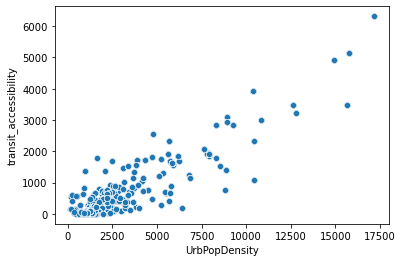

In [8]:
sns.scatterplot(data=X, x="UrbPopDensity", y="transit_accessibility")

<AxesSubplot:xlabel='UrbPopDensity', ylabel='IntersecDensity'>

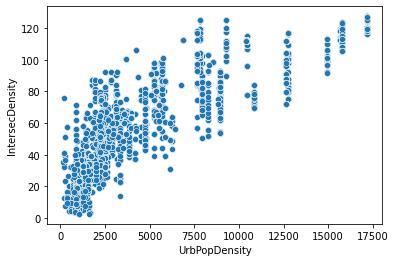

In [9]:
sns.scatterplot(data=X, x="UrbPopDensity", y="IntersecDensity")

In [10]:
X.drop(columns=['transit_accessibility','UrbBuildDensity'],inplace=True) # ,'IntersecDensity'
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

           Feature        VIF
0            const  88.809468
1    UrbPopDensity   4.929665
2    DistSubcenter   1.967136
3       DistCenter   2.598111
4  IntersecDensity   5.067125
5    street_length   1.843725
6  bike_lane_share   2.347567
7        LU_UrbFab   1.763700
8          LU_Comm   1.402297


,UrbPopDensity,DistSubcenter,DistCenter,IntersecDensity,street_length,bike_lane_share,LU_UrbFab,LU_Comm
UrbPopDensity,1.000,-0.538,-0.668,0.814,-0.455,0.742,0.501,-0.002
DistSubcenter,-0.538,1.000,0.638,-0.607,0.464,-0.461,-0.336,-0.279
DistCenter,-0.668,0.638,1.000,-0.713,0.439,-0.531,-0.354,-0.273
IntersecDensity,0.814,-0.607,-0.713,1.000,-0.645,0.581,0.560,0.140
street_length,-0.455,0.464,0.439,-0.645,1.000,-0.297,-0.436,-0.150
bike_lane_share,0.742,-0.461,-0.531,0.581,-0.297,1.000,0.275,0.083
LU_UrbFab,0.501,-0.336,-0.354,0.560,-0.436,0.275,1.000,-0.223
LU_Comm,-0.002,-0.279,-0.273,0.140,-0.150,0.083,-0.223,1.000


Rest of France (just Clermont and Toulouse in this case) has many high correlations. Best results come from dropping transit access, built-up density, and intersection density. 
Then highest VIF is 3.6, and just one correaltion too high, pop density and bike lane share (0.742)

In [11]:
X=vif_corr('France_other')
X_disp=[re.sub('FeatureO_','', x) for x in X.columns]
X.columns=X_disp
X=X.loc[:,['UrbPopDensity','DistSubcenter','DistCenter','UrbBuildDensity','IntersecDensity','street_length','bike_lane_share','transit_accessibility','LU_UrbFab','LU_Comm']]
X.drop(columns=['transit_accessibility','UrbBuildDensity','IntersecDensity'],inplace=True) # 
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

France_other France
           Feature        VIF
0            const  62.240592
1    UrbPopDensity   3.631147
2    DistSubcenter   1.954139
3       DistCenter   2.433508
4    street_length   1.532171
5  bike_lane_share   2.342071
6        LU_UrbFab   1.659941
7          LU_Comm   1.373728


,UrbPopDensity,DistSubcenter,DistCenter,street_length,bike_lane_share,LU_UrbFab,LU_Comm
UrbPopDensity,1.000,-0.538,-0.668,-0.455,0.742,0.501,-0.002
DistSubcenter,-0.538,1.000,0.638,0.464,-0.461,-0.336,-0.279
DistCenter,-0.668,0.638,1.000,0.439,-0.531,-0.354,-0.273
street_length,-0.455,0.464,0.439,1.000,-0.297,-0.436,-0.150
bike_lane_share,0.742,-0.461,-0.531,-0.297,1.000,0.275,0.083
LU_UrbFab,0.501,-0.336,-0.354,-0.436,0.275,1.000,-0.223
LU_Comm,-0.002,-0.279,-0.273,-0.150,0.083,-0.223,1.000


In [3]:
# all cities
city0='Berlin'
df0=pd.read_csv('../outputs/Combined/' + city0 + '_co_UF.csv')
df0['City']=city0
df_all=df0.copy()

cities0=['Dresden','Leipzig','Magdeburg','Potsdam','Frankfurt am Main','Düsseldorf','Kassel']
for city1 in cities0:
    print(city1)
    df1=pd.read_csv('../outputs/Combined/' + city1 + '_co_UF.csv')
    #print(len(df1.columns), 'columns in the data for ', city1)
    df1['City']=city1
    if len(df1.columns==df_all.columns):
        df_all=pd.concat([df_all,df1])
        print(city1, 'added.')
        print(len(df_all), 'rows in the combined dataframe')
df_all['HHNR']=df_all['City']+'_'+df_all['HHNR'].astype(int).astype(str)

df_DE=df_all.copy()
df_DE['Country']='Germany'
df_DE=df_DE.loc[:,( 'HHNR','Res_geocode',#'Dist_group', # IDs, trip geocodes, home-Res_geocode
'HHSize','IncomeDetailed_Numeric','HHType_simp','maxAgeHH',# household details, omit  'IncomeDetailed', 'HHType', 
'UniversityEducation', 'InEmployment', 'AllRetired', # personal-based details
'UrbPopDensity', 'UrbBuildDensity','DistSubcenter', 'DistCenter', 'transit_accessibility',
'bike_lane_share', 'IntersecDensity', 'street_length', 'LU_UrbFab', 'LU_Comm', 'Country',
# target: car ownership
'CarOwnershipHH')
]

city0='Clermont'
df0=pd.read_csv('../outputs/Combined/' + city0 + '_co_UF.csv')
df0['City']=city0
df_all=df0.copy()

cities0=['Toulouse']
for city1 in cities0:
    print(city1)
    df1=pd.read_csv('../outputs/Combined/' + city1 + '_co_UF.csv')
    #print(len(df1.columns), 'columns in the data for ', city1)
    df1['City']=city1
    if len(df1.columns==df_all.columns):
        df_all=pd.concat([df_all,df1])
        print(city1, 'added.')
        print(len(df_all), 'rows in the combined dataframe')
df_all['HHNR']=df_all['City']+'_'+df_all['HHNR'].astype(int).astype(str)

df_FR=df_all.copy()
df_FR['Country']='France'
df_FR=df_FR.loc[:,( 'HHNR','Res_geocode',#'Dist_group', # IDs, trip geocodes, home-Res_geocode
'HHSize','IncomeDetailed_Numeric','HHType_simp','maxAgeHH',# household details, omit  'IncomeDetailed', 'HHType', 
'UniversityEducation', 'InEmployment', 'AllRetired', # personal-based details
'UrbPopDensity', 'UrbBuildDensity','DistSubcenter', 'DistCenter', 'transit_accessibility',
'bike_lane_share', 'IntersecDensity', 'street_length', 'LU_UrbFab', 'LU_Comm', 'Country',
# target: car ownership
'CarOwnershipHH')
]

city0='Paris'
df0=pd.read_csv('../outputs/Combined/' + city0 + '_co_UF.csv')
df0['City']=city0
df_Paris=df0.copy()
df_Paris['Country']='France'

df_Paris=df_Paris.loc[:,( 'HHNR','Res_geocode',#'Dist_group', # IDs, trip geocodes, home-Res_geocode
'HHSize','IncomeDetailed_Numeric','HHType_simp','maxAgeHH',# household details, omit  'IncomeDetailed', 'HHType', 
'UniversityEducation', 'InEmployment', 'AllRetired', # personal-based details
'UrbPopDensity', 'UrbBuildDensity','DistSubcenter', 'DistCenter', 'transit_accessibility',
'bike_lane_share', 'IntersecDensity', 'street_length', 'LU_UrbFab', 'LU_Comm', 'Country',
# target: car ownership
'CarOwnershipHH')
]
df=pd.concat([df_DE,df_FR,df_Paris],ignore_index=True)

df.loc[df['HHType_simp'].isin(['Single_Female_Parent','Single_Male_Parent']),'HHType_simp']='Single_Parent'
df=df.loc[df['UrbPopDensity']<80000,]   
# remove high building density outliers (For Leipzig)
df=df.loc[df['UrbBuildDensity']<1e8,]   
df=df.loc[df['maxAgeHH']>0,]  
df.dropna(inplace=True)

# identify the feature columns
N_non_feature=2 # how many non-features are at the start of the df
cols=df.columns
newcols=(df.columns[:N_non_feature].tolist()) + ('FeatureO' +'_'+ cols[N_non_feature:-1]).tolist() + (df.columns[-1:].tolist())
# change column names
df.set_axis(newcols,axis=1,inplace=True)
df = df.reset_index(drop=True)
df0=df.copy()

# convert  all categorical variables to dummies
df_Cat=df.select_dtypes('object')[[col for col in df.select_dtypes('object').columns if "FeatureO" in col]]
for col in df_Cat:
    dum=pd.get_dummies(df[[col]])
    df = pd.concat([df, dum], axis = 1)
    # remove the original categorical columns
df.drop(df_Cat.columns.tolist(),axis=1,inplace=True)
# HPO with full dataset, grouping by individual person
target = 'CarOwnershipHH'

X=df[[col for col in df.columns if "FeatureO" in col]]

Dresden
Dresden added.
19437 rows in the combined dataframe
Leipzig
Leipzig added.
21207 rows in the combined dataframe
Magdeburg
Magdeburg added.
22642 rows in the combined dataframe
Potsdam
Potsdam added.
23546 rows in the combined dataframe
Frankfurt am Main
Frankfurt am Main added.
24442 rows in the combined dataframe
Düsseldorf
Düsseldorf added.
28077 rows in the combined dataframe
Kassel
Kassel added.
29417 rows in the combined dataframe
Toulouse
Toulouse added.
6897 rows in the combined dataframe


In [4]:
X_disp=[re.sub('FeatureO_','', x) for x in X.columns]
X.columns=X_disp
X=X.loc[:,['UrbPopDensity','DistSubcenter','DistCenter','UrbBuildDensity','IntersecDensity','street_length','bike_lane_share','transit_accessibility','LU_UrbFab','LU_Comm']]
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

                  Feature         VIF
0                   const  112.064971
1           UrbPopDensity    4.188736
2           DistSubcenter    1.351199
3              DistCenter    1.742990
4         UrbBuildDensity    5.079567
5         IntersecDensity    3.429587
6           street_length    2.419560
7         bike_lane_share    1.607800
8   transit_accessibility    4.538098
9               LU_UrbFab    2.027212
10                LU_Comm    1.401606


,UrbPopDensity,DistSubcenter,DistCenter,UrbBuildDensity,IntersecDensity,street_length,bike_lane_share,transit_accessibility,LU_UrbFab,LU_Comm
UrbPopDensity,1.000,-0.265,-0.353,0.789,0.543,-0.284,0.427,0.791,0.524,-0.061
DistSubcenter,-0.265,1.000,0.434,-0.304,-0.168,0.035,-0.245,-0.297,-0.135,-0.161
DistCenter,-0.353,0.434,1.000,-0.432,-0.379,0.362,-0.430,-0.444,-0.072,-0.156
UrbBuildDensity,0.789,-0.304,-0.432,1.000,0.530,-0.314,0.463,0.829,0.301,0.245
IntersecDensity,0.543,-0.168,-0.379,0.530,1.000,-0.727,0.422,0.498,0.524,-0.032
street_length,-0.284,0.035,0.362,-0.314,-0.727,1.000,-0.290,-0.241,-0.301,-0.020
bike_lane_share,0.427,-0.245,-0.430,0.463,0.422,-0.290,1.000,0.525,0.131,0.031
transit_accessibility,0.791,-0.297,-0.444,0.829,0.498,-0.241,0.525,1.000,0.425,0.106
LU_UrbFab,0.524,-0.135,-0.072,0.301,0.524,-0.301,0.131,0.425,1.000,-0.270
LU_Comm,-0.061,-0.161,-0.156,0.245,-0.032,-0.020,0.031,0.106,-0.270,1.000


With all cities, built-up density has high vif. highly correlated with pop dens and transit access. Removing built-up density solves the issue.

Then it's just pop density with transit accessibility (0.791)

In [6]:

X.drop(columns=['UrbBuildDensity'],inplace=True) 
X_selc = add_constant(X)
vif=pd.Series([variance_inflation_factor(X_selc.values, i) for i in range(X_selc.shape[1])], index=X_selc.columns)
vif=vif.to_frame().reset_index()
vif.columns=['Feature','VIF']
corr = X.corr()
print(vif)
corr.style.format(precision=3).background_gradient(cmap='coolwarm')

                 Feature         VIF
0                  const  111.887434
1          UrbPopDensity    3.188864
2          DistSubcenter    1.347234
3             DistCenter    1.742390
4        IntersecDensity    3.341770
5          street_length    2.413709
6        bike_lane_share    1.605818
7  transit_accessibility    3.467497
8              LU_UrbFab    1.901266
9                LU_Comm    1.232707


,UrbPopDensity,DistSubcenter,DistCenter,IntersecDensity,street_length,bike_lane_share,transit_accessibility,LU_UrbFab,LU_Comm
UrbPopDensity,1.000,-0.265,-0.353,0.543,-0.284,0.427,0.791,0.524,-0.061
DistSubcenter,-0.265,1.000,0.434,-0.168,0.035,-0.245,-0.297,-0.135,-0.161
DistCenter,-0.353,0.434,1.000,-0.379,0.362,-0.430,-0.444,-0.072,-0.156
IntersecDensity,0.543,-0.168,-0.379,1.000,-0.727,0.422,0.498,0.524,-0.032
street_length,-0.284,0.035,0.362,-0.727,1.000,-0.290,-0.241,-0.301,-0.020
bike_lane_share,0.427,-0.245,-0.430,0.422,-0.290,1.000,0.525,0.131,0.031
transit_accessibility,0.791,-0.297,-0.444,0.498,-0.241,0.525,1.000,0.425,0.106
LU_UrbFab,0.524,-0.135,-0.072,0.524,-0.301,0.131,0.425,1.000,-0.270
LU_Comm,-0.061,-0.161,-0.156,-0.032,-0.020,0.031,0.106,-0.270,1.000
